<a href="https://colab.research.google.com/github/prashantkartikay/Covid-Detection-using-Ct-scan/blob/main/Ct_Scan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow
import os
import tensorflow as tf
from PIL import Image


In [ ]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
disease_types=['COVID','non-COVID']
data_dir='/content/drive/MyDrive/Ct-Scan'
train_dir=os.path.join(data_dir)
print(data_dir)
print(train_dir)

/content/drive/MyDrive/Ct-Scan
/content/drive/MyDrive/Ct-Scan


In [ ]:
train_data=[]
i=0
for id,sp in enumerate(disease_types):
  for file in os.listdir(os.path.join(data_dir,sp)):
    if(i==0):
      #cv2.imshow(cv2.imread('{}/{}'.format(os.path.join(data_dir,sp),file)))
      im = cv2.imread('{}/{}'.format(os.path.join(data_dir,sp),file))
      w,h,c=im.shape
      print(c)
      i+=1
    train_data.append(['{}/{}'.format(os.path.join(data_dir,sp),file),id,sp])


3


In [ ]:
train=pd.DataFrame(train_data,columns=['File','DiseaseId','Disease Type'])

In [ ]:
train.head()

,File,DiseaseId,Disease Type
0,/content/drive/MyDrive/Ct-Scan/COVID/Covid (1)...,0,COVID
1,/content/drive/MyDrive/Ct-Scan/COVID/Covid (10...,0,COVID
2,/content/drive/MyDrive/Ct-Scan/COVID/Covid (10...,0,COVID
3,/content/drive/MyDrive/Ct-Scan/COVID/Covid (10...,0,COVID
4,/content/drive/MyDrive/Ct-Scan/COVID/Covid (10...,0,COVID


In [ ]:
train=train.sample(frac=1,random_state=200)
train.index=np.arange(len(train))
train.head()

,File,DiseaseId,Disease Type
0,/content/drive/MyDrive/Ct-Scan/non-COVID/Non-C...,1,non-COVID
1,/content/drive/MyDrive/Ct-Scan/non-COVID/Non-C...,1,non-COVID
2,/content/drive/MyDrive/Ct-Scan/COVID/Covid (34...,0,COVID
3,/content/drive/MyDrive/Ct-Scan/COVID/Covid (12...,0,COVID
4,/content/drive/MyDrive/Ct-Scan/non-COVID/Non-C...,1,non-COVID


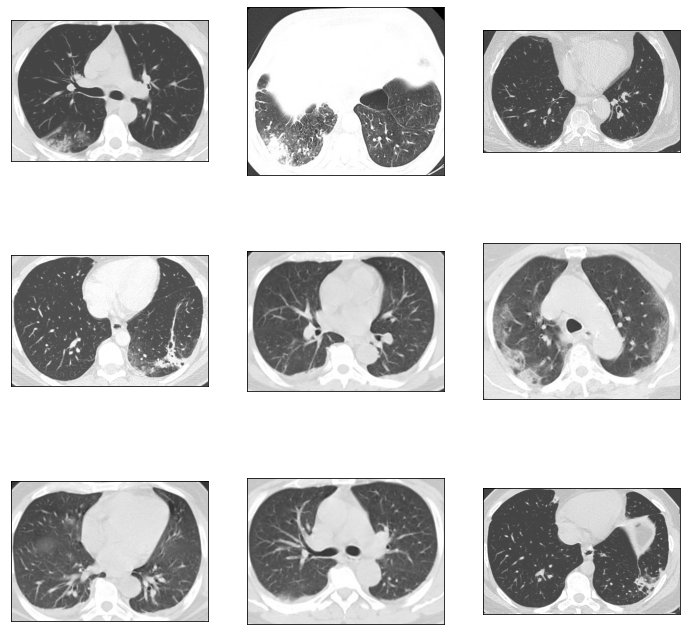

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 3, 3)

In [ ]:
image_size=224
def read_image(filepath):
  return cv2.imread(filepath)
def resize_image(image,image_size):
  return cv2.resize(image.copy(),image_size,interpolation=cv2.INTER_AREA)

In [ ]:
x_trai=np.zeros((train.shape[0],image_size,image_size,3))
for i,file in tqdm(enumerate(train['File'].values)):
  image=read_image(file)
  if image is not None:
    x_trai[i]=resize_image(image,(image_size,image_size))
x_trai=x_trai/255.
print('train shape: {}'.format(x_trai.shape))


2080it [17:43,  1.96it/s]


train shape: (2080, 224, 224, 3)


In [ ]:

y_trai=train['DiseaseId'].values
y_trai=to_categorical(y_trai,num_classes=2)
print(y_trai.shape)
x_trai.shape

(2080, 2)


(2080, 224, 224, 3)

In [ ]:
batch_size=6
x_train,x_val,y_train,y_val=train_test_split(x_trai,y_trai,test_size=0.3,random_state=200,stratify=y_trai)

In [ ]:
print('x_train: ',x_train.shape)
print('x_val: ',x_val.shape)
print('y_train: ',y_train.shape)
print('y_val: ',y_val.shape)


x_train:  (1456, 224, 224, 3)
x_val:  (624, 224, 224, 3)
y_train:  (1456, 2)
y_val:  (624, 2)


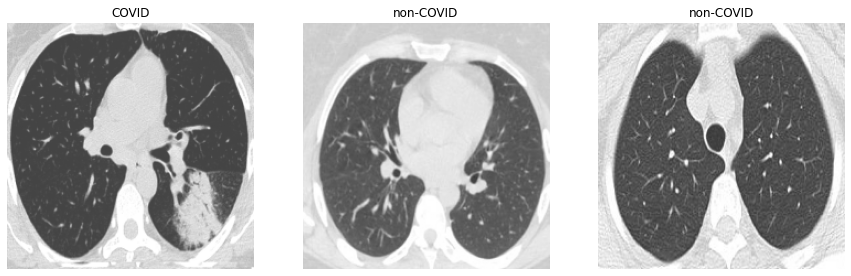

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])
    ax[i].set_title(disease_types[np.argmax(y_train[i])])

In [ ]:
epoch=50
size=224
n_ch=3

In [ ]:
# imports for the model
from tensorflow.keras import Sequential, Model,Input
from tensorflow.keras.layers import Dense, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

# imports for the dataset
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications import DenseNet121


In [ ]:
#def build_resnet50():
resnet= DenseNet121(weights='imagenet', include_top=False)
input=Input(shape=(224,224,3))
    
#x = Conv2D(3, (3, 3), activation='relu', padding='same')(input)
for layer in resnet.layers:
    layer.trainable = False
x = resnet.output
    
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# multi output
output = Dense(2,activation = 'softmax', name='root')(x)
 

# model
model = Model(resnet.input,output)
    
optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()
        
#return model

29089792/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
_____________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:


#model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True)

datagen.fit(x_train)

In [ ]:

from keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(min_delta=0.001,mode='max',monitor='val_accuracy',patience=2)
callback=[early_stopping]

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model,to_file='convert.png',show_shapes=True,show_layer_names=True)
Image(filename='convert.png')

In [ ]:
history = model.fit(x_train, y_train, batch_size=50,
               epochs=50,
               verbose=1,
               callbacks=[annealer],
               validation_data=(x_val, y_val))

Epoch 1/50
30/30 [==============================] - 47s 341ms/step - loss: 0.6791 - accuracy: 0.6614 - val_loss: 0.9226 - val_accuracy: 0.4279
Epoch 2/50
30/30 [==============================] - 6s 196ms/step - loss: 0.3502 - accuracy: 0.8516 - val_loss: 0.8345 - val_accuracy: 0.4455
Epoch 3/50
30/30 [==============================] - 6s 197ms/step - loss: 0.2339 - accuracy: 0.9080 - val_loss: 0.7123 - val_accuracy: 0.5337
Epoch 4/50
30/30 [==============================] - 6s 199ms/step - loss: 0.1909 - accuracy: 0.9313 - val_loss: 0.5605 - val_accuracy: 0.6603
Epoch 5/50
30/30 [==============================] - 6s 200ms/step - loss: 0.1355 - accuracy: 0.9609 - val_loss: 0.4412 - val_accuracy: 0.7788
Epoch 6/50
30/30 [==============================] - 6s 200ms/step - loss: 0.1192 - accuracy: 0.9663 - val_loss: 0.3240 - val_accuracy: 0.8510
Epoch 7/50
30/30 [==============================] - 6s 199ms/step - loss: 0.0938 - accuracy: 0.9753 - val_loss: 0.2538 - val_accuracy: 0.8878
Epoch

In [ ]:
y_pred = model.predict(x_val)
y_pred=np.argmax(y_pred,axis=1)
y_val=np.argmax(y_val,axis=1)

In [ ]:
cm=confusion_matrix(y_pred,y_val)
print(cm)

[[243   9]
 [ 12 360]]


In [ ]:
from sklearn.metrics import classification_report
classification_report(y_pred,y_val)

'              precision    recall  f1-score   support\n\n           0       0.95      0.96      0.96       252\n           1       0.98      0.97      0.97       372\n\n    accuracy                           0.97       624\n   macro avg       0.96      0.97      0.97       624\nweighted avg       0.97      0.97      0.97       624\n'

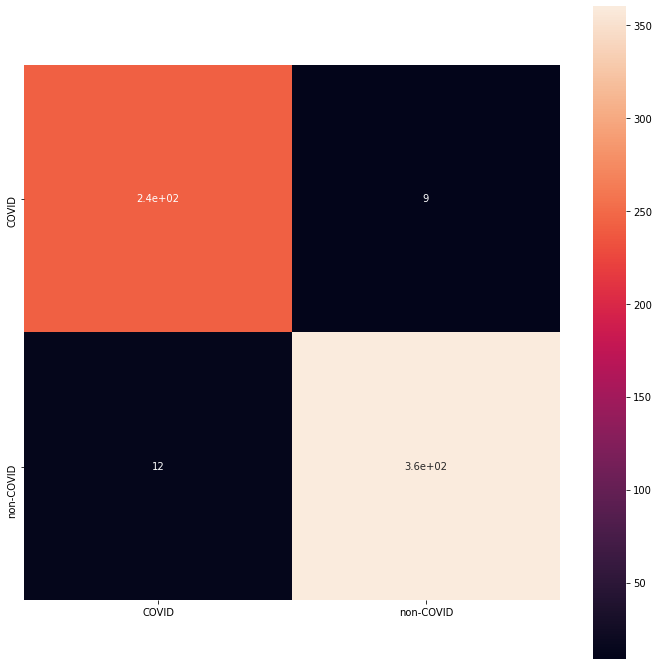

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(cm,annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)

plt.show()

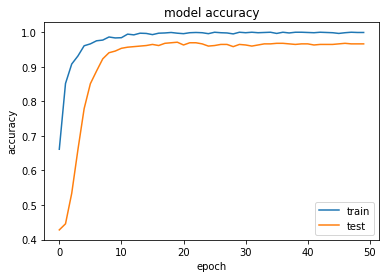

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
from tensorflow import lite

In [ ]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [ ]:
keras_model_name="tf_model.h5"
model.save(keras_model_name)
convert_bytes(os.path.getsize(keras_model_name),"MB")

File size: 31.051 Megabytes


In [ ]:
labels=['COVID','non-COVID']

with open('label.txt','w')as f:
  f.write('\n'.join(labels))

In [ ]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "MB")


In [ ]:
interpreter = tf.lite.Interpreter(model_content=TF_LITE_MODEL_FILE_NAME)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details= interpreter.get_output_details()
print(input_details, output_details)
